# Pneumonia Prediction using CNN

## Importing the dependinces

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

2024-04-14 08:37:39.091531: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 08:37:39.091634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 08:37:39.093548: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **Data Preprocessing**

In [2]:
def get_data(data_dir, img_size, labels):
    data = []  # List to store image data and labels

    # Iterate through each label
    for label in labels:
        path = os.path.join(data_dir, label)  # Path to label directory
        class_num = labels.index(label)  # Assign a numerical label

        # Iterate through each image in the label directory
        for img in os.listdir(path):
            try:
                # Read image in grayscale and resize it
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))

                # Append resized image and its label to the data list
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)  # Print any exceptions that occur during image processing

    # Shuffle the data to ensure randomness
    np.random.shuffle(data)
    
    # Separate image data and labels
    images = np.array([item[0] for item in data])
    labels = np.array([item[1] for item in data])

    return images, labels

In [3]:
labels = ['PNEUMONIA', 'NORMAL']  # Define labels
img_size = 128
X_train, y_train = get_data('/kaggle/input/chest-xray-pneumonia/chest_xray/train', img_size, labels)
X_test, y_test = get_data('/kaggle/input/chest-xray-pneumonia/chest_xray/test', img_size, labels)
X_val, y_val = get_data('/kaggle/input/chest-xray-pneumonia/chest_xray/val', img_size, labels)

In [4]:
positive = [] # means there is PNEUMONIA
negative = [] # means there is not PNEUMONIA
for i in range(len(y_train)):
    if y_train[i]:
        negative.append(X_train[i])
    else:
        positive.append(X_train[i])

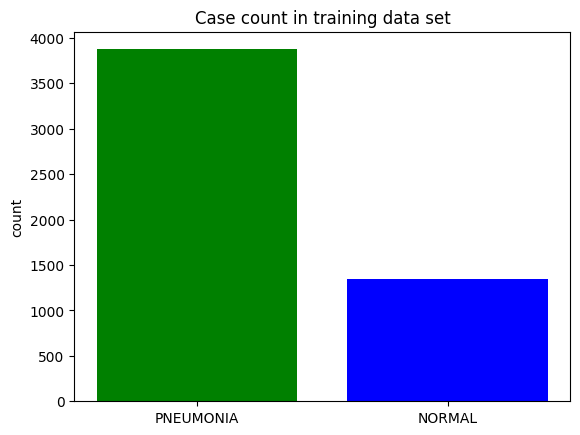

In [5]:
plt.bar(labels,[len(positive),len(negative)], color=['green','blue'])
plt.title('Case count in training data set')
plt.ylabel('count')
plt.show()

**we have imbalanced data**

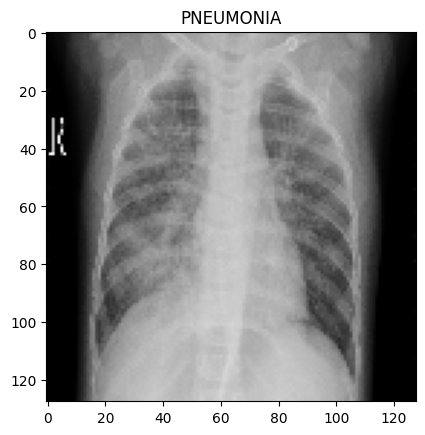

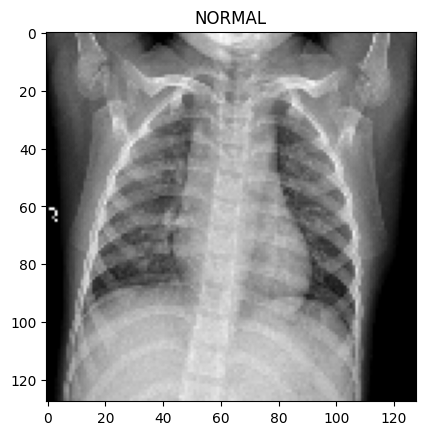

In [6]:
plt.imshow(positive[4] ,cmap='gray')
plt.title('PNEUMONIA')
plt.show()

plt.imshow(negative[4], cmap='gray')
plt.title('NORMAL')
plt.show()

In [7]:
# Normalize the data
X_train = np.array(X_train) / 255
X_val = np.array(X_val) / 255
X_test = np.array(X_test) / 255

In [8]:
# resize data for deep learning 
X_train = X_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

X_val = X_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

X_test = X_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [9]:
X_train[0].shape

(128, 128, 1)

## Data augmentation

In [10]:
# Create an instance of ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,  # randomly rotate images 
    width_shift_range=0.1,  # randomly shift images horizontally 
    height_shift_range=0.1,  # randomly shift images vertically 
    shear_range=0.1,  # randomly apply shearing transformations
    zoom_range=0.2,  # randomly zoom 
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest' 
)

datagen.fit(X_train)

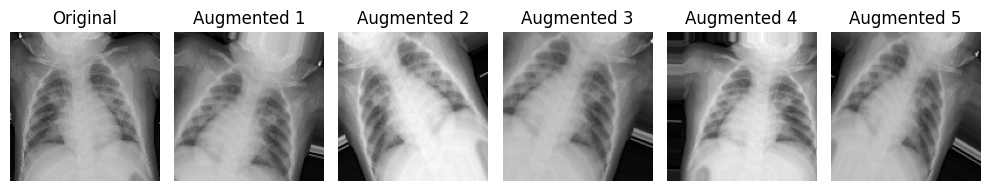

In [11]:
# Choose a sample image from X_train
sample_image = X_train[0]

# Reshape the image to (1, img_size, img_size, 1) as required by the ImageDataGenerator
sample_image = sample_image.reshape((1,) + sample_image.shape)

# Generate augmented images using the datagen instance
num_augmented_images = 5
augmented_images = [next(datagen.flow(sample_image))[0] for _ in range(num_augmented_images)]

# Plot the original and augmented images
plt.figure(figsize=(10, 5))
for i in range(num_augmented_images + 1):
    plt.subplot(1, num_augmented_images + 1, i + 1)
    if i == 0:
        plt.imshow(sample_image[0, :, :, 0], cmap='gray')
        plt.title('Original')
    else:
        plt.imshow(augmented_images[i - 1][:, :, 0], cmap='gray')
        plt.title('Augmented {}'.format(i))

    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience = 2,
                                            verbose=1,
                                            factor=0.3,
                                            min_lr=0.000001)

In [13]:
# Define the Sequential model
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(32, (3, 3), strides=1, activation='relu', input_shape=(128, 128, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2))

# Second Convolutional Layer
model.add(Conv2D(64, (3, 3), strides=1, activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2))

# Third Convolutional Layer
model.add(Conv2D(64, (3, 3), strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2))

# Fourth Convolutional Layer
model.add(Conv2D(128, (3, 3), strides=1, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2))

# Fifth Convolutional Layer
model.add(Conv2D(256, (3, 3), strides=1, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2))

# Flatten layer to transition from convolutional to dense layers
model.add(Flatten())

# First Fully connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

# Second Fully connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 574,785 (2.19 MB)

 Trainable params: 573,697 (2.19 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [14]:
my_model = model.fit(datagen.flow(X_train,y_train, batch_size = 32) ,epochs = 12,validation_data = datagen.flow(X_val, y_val),callbacks = [learning_rate_reduction])

Epoch 1/12


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 144s 848ms/step - accuracy: 0.8207 - loss: 0.4044 - val_accuracy: 0.5000 - val_loss: 7.4923 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 843ms/step - accuracy: 0.9111 - loss: 0.2244 - val_accuracy: 0.5000 - val_loss: 4.9937 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - accuracy: 0.9218 - loss: 0.1913
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 849ms/step - accuracy: 0.9219 - loss: 0.1913 - val_accuracy: 0.5000 - val_loss: 4.3966 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 846ms/step - accuracy: 0.9388 - loss: 0.1662 - val_accuracy: 0.6875 - val_loss: 0.9542 - learning_rate: 3.0000e-04
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 144s 860ms/step - accuracy: 0.9409 - loss: 0.1497 - val_accuracy: 0.6250 - val_loss: 0.9393 - learning_rate: 3.0000e-04
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.94

In [15]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.9282 - loss: 0.2073
Loss of the model is -  0.21022160351276398
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.9282 - loss: 0.2073
Accuracy of the model is -  92.30769276618958 %


In [16]:
# Save the entire model
# model.save('kaggle/working/pneumonia_prediction_model.h5')

# Model Evaluation

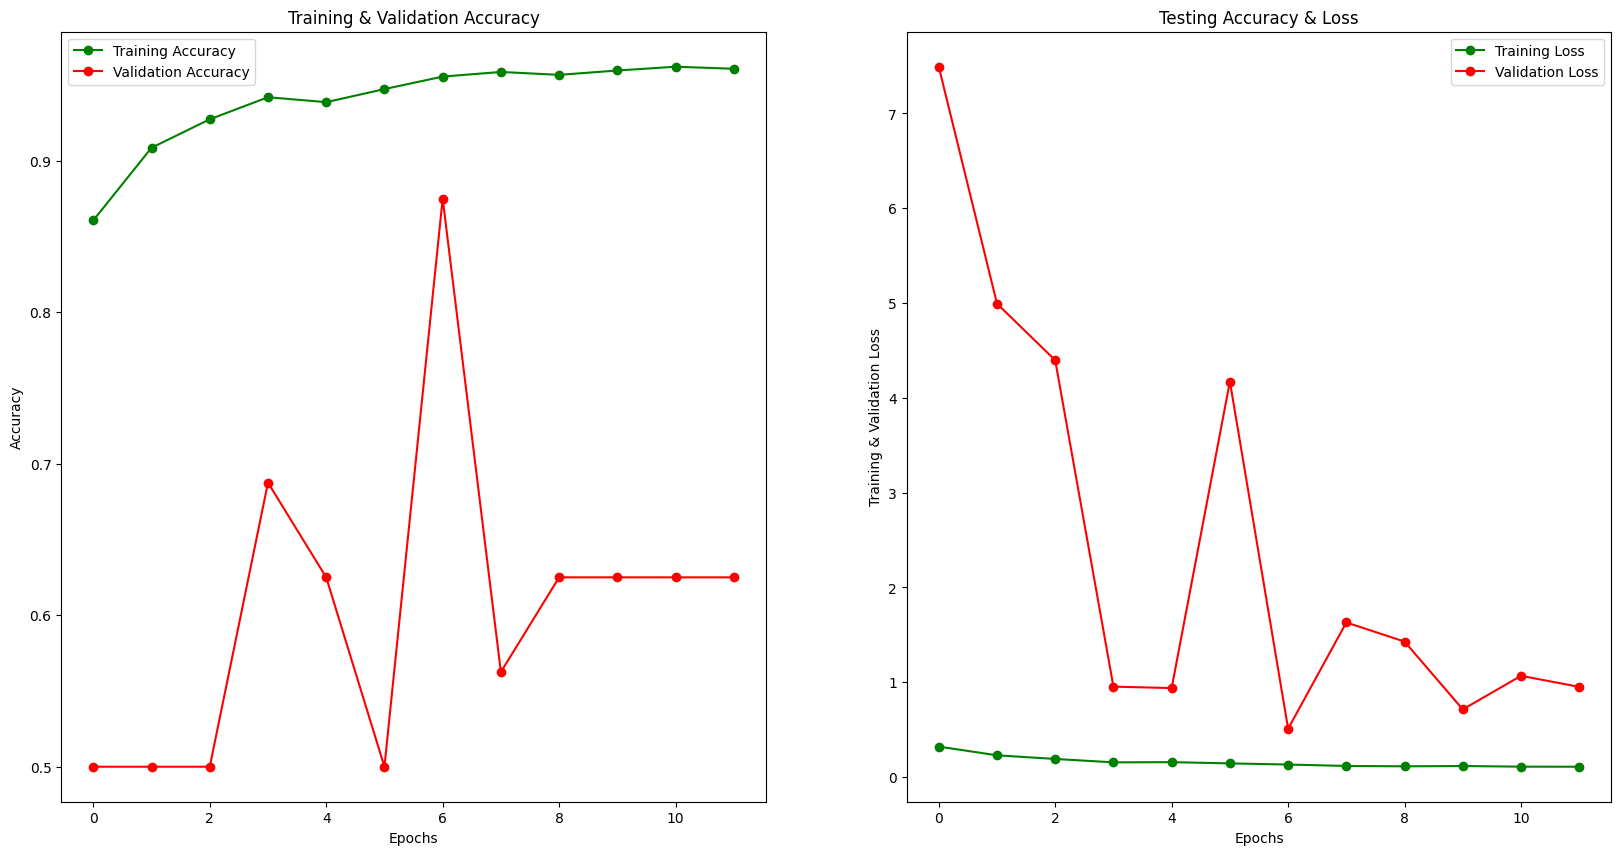

In [17]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = my_model.history['accuracy']
train_loss = my_model.history['loss']
val_acc = my_model.history['val_accuracy']
val_loss = my_model.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [18]:
predictions = model.predict(X_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step


In [19]:
# Convert predicted probabilities to binary class labels
predictions_binary = (predictions > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, predictions_binary, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.95      0.94       390
   Normal (Class 1)       0.91      0.88      0.90       234

           accuracy                           0.92       624
          macro avg       0.92      0.91      0.92       624
       weighted avg       0.92      0.92      0.92       624



<Axes: >

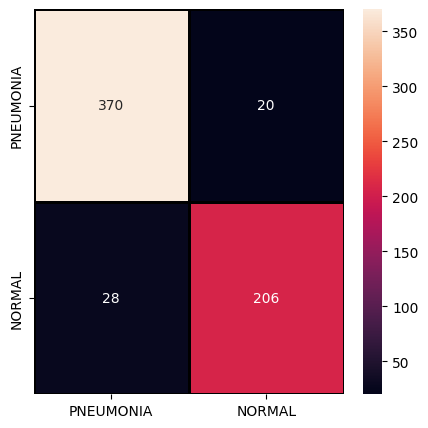

In [20]:
cm = confusion_matrix(y_test,predictions_binary)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (5,5))
sns.heatmap(cm, linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

## Model Test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


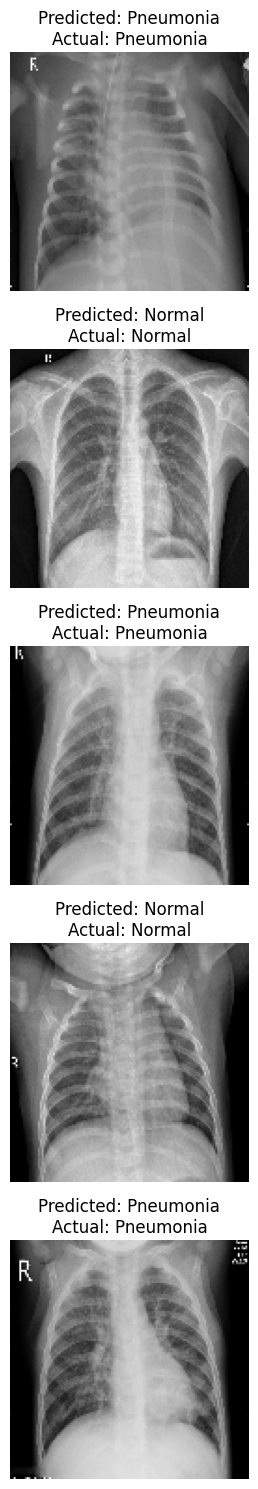

In [26]:
# Select 5 random indices from the test data
random_indices = np.random.choice(len(X_test), size=5, replace=False)

# Create a figure with subplots arranged vertically
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(5, 15))

# Iterate over the random indices
for i, idx in enumerate(random_indices):
    # Get the image, predicted label, and actual label for the random index
    sample_image = X_test[idx]
    predicted_label = model.predict(np.expand_dims(sample_image, axis=0))[0]
    actual_label = y_test[idx]

    # Convert the predicted and actual labels to human-readable format
    predicted_label = 'Pneumonia' if predicted_label <= 0.5 else 'Normal'
    actual_label = 'Pneumonia' if actual_label == 0 else 'Normal'

    # Display the image along with the predicted and actual labels
    axes[i].imshow(sample_image.squeeze(), cmap='gray')
    axes[i].set_title(f'Predicted: {predicted_label}\nActual: {actual_label}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Saving Model

In [ ]:
# Save the entire model
model.save('kaggle/working/pneumonia_prediction_model.h5')